In [4]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-34d4c781-02a4-f16e-979d-da3a69b93da5)


In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 5.3 MB/s 
     |████████████████████████████████| 462 kB 31.9 MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
import keras
from matplotlib import pyplot as plt
import numpy as np


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Spring2022/gender-detection/tweets/train_no_rt.csv')
# df.drop(['Unnamed: 0.1'], axis=1, inplace=True)
# df['label'].value_counts()
# print(11899/11520)
# df.columns
df['class']=df['label'].apply(lambda x: 1 if x=='Female' else 0)
df.head(5)


,Unnamed: 0,Unnamed: 0.1,twitter_id,date,tweet,label,class
0,2,2,1194696969672724480,2019-11-13 19:22:08+00:00,"b'What is this shit, I\xe2\x80\x99m trying to ...",Male,0
1,3,3,966392069680975872,2018-02-21 19:19:58+00:00,b'So much love and respect for this extremely ...,Female,1
2,4,4,1407118629959700483,2021-06-21 23:29:59+00:00,b'You can still believe in doge coin and swing...,Male,0
3,5,5,1486082117339521025,2022-01-25 21:02:41+00:00,b'@JustinLaRocca Oaff. This got me. \xf0\x9f\x...,Female,1
4,6,6,1259904487822635008,2020-05-11 17:53:32+00:00,"b'Hey loves, catch me performing today on @The...",Female,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['tweet'],df['class'], stratify=df['class'],random_state=42)


In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])

l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

model = tf.keras.Model(inputs=[text_input], outputs = [l])

model.summary()
#12 hidden layer(Transformer blocks)
# a hidden size of H=768, and A=12 attention heads
#Text inputs have been normalized the "uncased" way, meaning that the text has 
# been lower-cased before tokenization into word pieces, and any accent markers 
# have been stripped

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
 loss='binary_crossentropy',
 metrics=METRICS)

In [ ]:
history=model.fit(X_train, y_train, epochs=5)


Epoch 1/5
439/439 [==============================] - 301s 676ms/step - loss: 0.5911 - accuracy: 0.6751 - precision: 0.6563 - recall: 0.6673
Epoch 2/5
439/439 [==============================] - 294s 669ms/step - loss: 0.5369 - accuracy: 0.7261 - precision: 0.7117 - recall: 0.7143
Epoch 3/5
439/439 [==============================] - 294s 669ms/step - loss: 0.5150 - accuracy: 0.7421 - precision: 0.7277 - recall: 0.7327
Epoch 4/5
439/439 [==============================] - 293s 667ms/step - loss: 0.5037 - accuracy: 0.7488 - precision: 0.7371 - recall: 0.7346
Epoch 5/5
439/439 [==============================] - 295s 671ms/step - loss: 0.4910 - accuracy: 0.7580 - precision: 0.7464 - recall: 0.7453


In [ ]:
# tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76 )


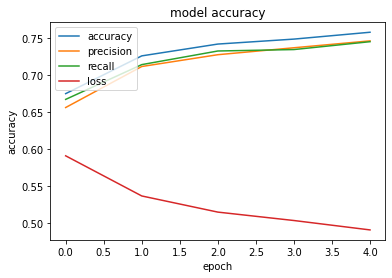

In [ ]:
import matplotlib.pyplot as plt

# history = model1.fit(train_x, train_y,validation_split = 0.1, epochs=50, batch_size=4)
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.plot(history.history['precision'])
plt.plot(history.history['recall'])
plt.plot(history.history['loss'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy','precision','recall','loss'], loc='upper left')
plt.show()

In [ ]:
results = model.evaluate(X_test, y_test)

147/147 [==============================] - 109s 729ms/step - loss: 0.4708 - accuracy: 0.7813 - precision: 0.7600 - recall: 0.7904


In [ ]:
print(results)

[0.4708099067211151, 0.7813168168067932, 0.7600345015525818, 0.7903949618339539]


In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [ ]:

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 0, ..., 0, 1, 1])

In [ ]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_predicted)

print(cf_matrix)

[[1894  556]
 [ 467 1761]]


In [ ]:
cf_matrix.diagonal()/cf_matrix.sum(axis=1)

array([0.77306122, 0.79039497])

In [ ]:
# import matplotlib as plt
# import seaborn as sns


# ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

# ax.set_title('Seaborn Confusion Matrix with labels\n\n');
# ax.set_xlabel('\nPredicted Values')
# ax.set_ylabel('Actual Values ');

# ## Ticket labels - List must be in alphabetical order
# ax.xaxis.set_ticklabels(['Male','Female'])
# ax.yaxis.set_ticklabels(['Male','Female'])

# ## Display the visualization of the Confusion Matrix.
# # plt.show()

[Text(0, 0.5, 'Male'), Text(0, 1.5, 'Female')]

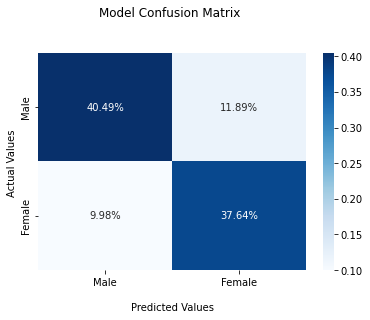

In [ ]:
import matplotlib as plt
import seaborn as sns

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Model Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Male','Female'])
ax.yaxis.set_ticklabels(['Male','Female'])

## Display the visualization of the Confusion Matrix.
# plt.show()

In [ ]:
# model test function
def eval_model(predictions):
    print(accuracy_score(y_test, predictions))
    # Compute fpr, tpr, thresholds and roc auc
    fpr, tpr, thresholds = roc_curve(np.array(y_test), np.array(predictions))
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    # print(classification_report(y_test, np.array(predictions), target_names=["not disaster", "disaster"]))

eval_model(final_predictions)

In [ ]:
test_case=["b'RT @FieldYates: Broncos HC Vic Fangio thought the Ravens\xe2\x80\x99 run at the end of the game was \xe2\x80\x9ckind of bull****\xe2\x80\x9d and notes he\xe2\x80\x99s never seen anyth\xe2\x80\xa6'"]
model.predict(test_case)
y=np.where(model.predict(test_case) > 0.5, 'Female', 'Male')
y[0][0]

'Male'

In [ ]:
model.save("/content/gdrive/MyDrive/Spring2022/gender-detection/BERT_noret_noemoj/Bert_1")
model.save_weights("/content/gdrive/MyDrive/Spring2022/gender-detection/BERT_noret_noemoj/w/Bert_1")
model.save_weights("/content/gdrive/MyDrive/Spring2022/gender-detection/BERT_noret_noemoj/h5/Bert_1", save_format="h5")

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Spring2022/gender-detection/BERT_noret_noemoj/Bert_1/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Spring2022/gender-detection/BERT_noret_noemoj/Bert_1/assets


OSError: ignored

In [ ]:
y_predicted

array([0, 0, 1, ..., 1, 1, 0])

In [ ]:
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()
# frames = [y_test, y_predicted]

out_df = pd.DataFrame(list(zip(X_test, y_test, y_pred, y_predicted)),columns =['tweets', 'class','prediction', 'binary_pred'])
out_df.to_csv('/content/gdrive/MyDrive/Spring2022/gender-detection/BERT_5ep_full/results.csv') 

In [ ]:
from tensorflow import keras
model = keras.models.load_model('path/to/location')

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Spring2022/gender-detection/tweets/train_2.csv')



print('Average word length of tweet in dataset is {0:.0f}.'.format(np.mean(df['tweet'].apply(lambda x: len(x.split())))))
print('Max word length of tweet in dataset is {0:.0f}.'.format(np.max(df['tweet'].apply(lambda x: len(x.split())))))
print('Average character length of tweet in dataset is {0:.0f}.'.format(np.mean(df['tweet'].apply(lambda x: len(x)))))

Average word length of tweet in dataset is 15.
Max word length of tweet in dataset is 63.
Average character length of tweet in dataset is 123.


In [ ]:
df

,Unnamed: 0,tweet,label
0,0,b'Loving the makeover Maria! (You tart) #Sound...,Female
1,1,b'Anna Kendrick looks hot. No bra. Well played.',Male
2,2,b'\xf0\x9f\x94\x91\xf0\x9f\x94\x91\xf0\x9f\x94...,Female
3,3,b'the photo booth was a big hit last night \xf...,Female
4,4,b'Titans\xe2\x80\x99 free-agent linebacker Ras...,Male
...,...,...,...
99514,99514,"b'A year in the making, @SKIMS Velour is my mo...",Female
99515,99515,b'FAM https://t.co/RHDz5wZJr3',Female
99516,99516,b'.@MarioLopezExtra hope you had fun ;)',Female
99517,99517,b'RT @natgilmore: Soo blessed and grateful to ...,Male


Average word length of tweet in dataset is 15.


Text(0.5, 1.0, 'Distribution of female tweets')

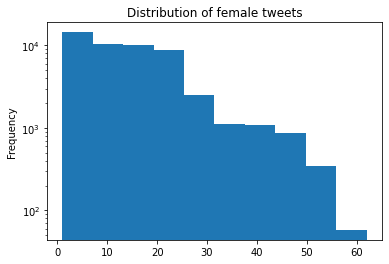

In [ ]:
new_df = (df[(df['label'] == 'Female')])
print('Average word length of tweet in dataset is {0:.0f}.'.format(np.mean(new_df['tweet'].apply(lambda x: len(x.split())))))
# print('Average word length of tweet in dataset is {0:.0f}.'.format(np.mean(new_df['tweets'].apply(lambda x: len(x.split())))))

new_df['tweet'].apply(lambda x: len(x.split())).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of female tweets')

Text(0.5, 1.0, 'Distribution of tweet length in words')

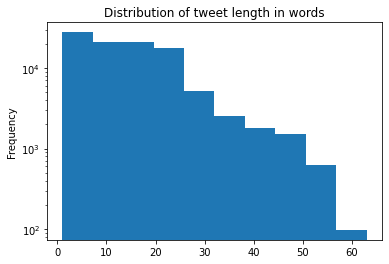

In [ ]:
# whole SET 

df['tweet'].apply(lambda x: len(x.split())).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of tweet length in words')

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Spring2022/gender-detection/BERT_5ep_full/results.csv')
df

,Unnamed: 0,tweets,class,prediction,binary_pred
0,0,b'The Tonight Show: At Home Edition (@itsgabri...,0,0.345087,0
1,1,"b""Dear media: Just because David and I will so...",0,0.404336,0
2,2,b'Thank you! @DemarcoDaDon @iRuntown #nowahala...,0,0.654620,1
3,3,b'To the final episode of #KUWTK \xf0\x9f\x8e\...,1,0.750080,1
4,4,b'Just posted a photo https://t.co/uHnuxBrlgu',0,0.567649,1
...,...,...,...,...,...
24875,24875,b'Growing up i was taught respect comes from a...,0,0.577973,1
24876,24876,b'#Company https://t.co/xICp1o7UwT',0,0.573875,1
24877,24877,b'Thank u @faspiras @SarahTanno for the beauti...,1,0.872757,1
24878,24878,b'\xe2\x9a\xa1\xef\xb8\x8fTime for the rest of...,1,0.657644,1


In [ ]:

# readinag given csv file
# and creating dataframe
# dataframe1 = pd.read_csv("/content/emojies.txt",delimiter = ' ')
  
# storing this dataframe in a csv file
# dataframe1.to_csv('emojies.csv', 
#                   index = None)


# dataframe1
emojies = pd.read_csv("/content/emojies.csv")
emojies.drop(['Native'],axis=1, inplace=True)
emojies

dict_1 = dict(zip(emojies.Bytes, emojies.Description))
dict_1

In [ ]:
#!/usr/bin/env python
import re

# text="b'To the final episode of #KUWTK \\xf0\\x9f\\x8e\\x89 https://t.co/IKmt93tLy9'"
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def deEmojify(x): 
  x=remove_urls(x)
  x=x.upper()
  x= x.replace('X', 'x')
  # print(x)

  for key, value in dict_1.items():
    # print(key)
    # value=str(value[0])
    # re.sub('\\+', '\\', x)
    x= x.replace(key, value)
    # x = re.sub(key, value, x)
    # print(x)
  return x

text=remove_urls(text)
# deEmojify(text)
deEmojify(df.iloc[3]['tweets'])
# print(df.iloc[3]['tweets'])

"B'TO THE FINAL EPISODE OF #KUWTK PARTY POPPER "

# replacing emotions with word

In [ ]:
def retweet(x): 
  x=remove_urls(x)
  [x for x in df['tweet'] if not x.startswith('b\'RT')]
  
  return x

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Spring2022/gender-detection/tweets/train.csv')
# df['cl_tweet']=df['tweet'].apply(lambda x: deEmojify(x))

# new_df['tweet'].apply(lambda x: len(x.split()))
# df=df['tweet'].str.contains('b\'RT')==False
df=df[~df.tweet.str.contains("b\'RT")]

df

,Unnamed: 0,twitter_id,date,tweet,label
2,2,1194696969672724480,2019-11-13 19:22:08+00:00,"b'What is this shit, I\xe2\x80\x99m trying to ...",Male
3,3,966392069680975872,2018-02-21 19:19:58+00:00,b'So much love and respect for this extremely ...,Female
4,4,1407118629959700483,2021-06-21 23:29:59+00:00,b'You can still believe in doge coin and swing...,Male
5,5,1486082117339521025,2022-01-25 21:02:41+00:00,b'@JustinLaRocca Oaff. This got me. \xf0\x9f\x...,Female
6,6,1259904487822635008,2020-05-11 17:53:32+00:00,"b'Hey loves, catch me performing today on @The...",Female
...,...,...,...,...,...
23410,23410,1130459394452406272,2019-05-20 13:04:57+00:00,b'Quando as dificuldades nos cercam e n\xc3\xa...,Female
23413,23413,1184562835235360768,2019-10-16 20:12:42+00:00,b'I love this question!\nMy word is EXCELLENCE...,Female
23414,23414,1387875328547201024,2021-04-29 21:03:58+00:00,b'An Idaho lawmaker facing rape allegations fr...,Female
23416,23416,1382355727457525764,2021-04-14 15:31:03+00:00,b'\xf0\x9f\x91\x80\xf0\x9f\x91\x80 @blkblockch...,Male


In [ ]:
df.to_csv('/content/gdrive/MyDrive/Spring2022/gender-detection/tweets/train_no_rt.csv') 

In [ ]:
# a_df = (df[(df['class'] == 1)&(df['binary_pred'] == 0)])
# df.drop(['Unnamed: 0'],axis=1, inplace=True)
qual = df.groupby("class").agg([np.mean, np.std])

qual

prediction           binary_pred          
            mean       std        mean       std
class                                           
0       0.457714  0.185805    0.436942  0.496028
1       0.628670  0.166125    0.783825  0.411651

In [ ]:
a_df = (df[(df['class'] == 0)&(df['binary_pred'] == 1)])
# a_df['prediction'].mean
# plt.yscale('log');
# plt.title('Distribution of tweet length in words')


In [ ]:
a_df

In [ ]:
df.iloc[6]['tweets']

"b'\\xf0\\x9f\\x99\\x8c https://t.co/S3TaDIOAjG'"

In [ ]:
!pip install text2emotion

     |████████████████████████████████| 57 kB 2.4 MB/s 
     |████████████████████████████████| 175 kB 9.9 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=988f7c996c0f0ab05a08c8eaa84229313b7b4541f842e56df63004862460dae8
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [ ]:
import text2emotion as te
te.get_emotion(df.iloc[6]['tweets'])

{'Angry': 0, 'Fear': 0, 'Happy': 0, 'Sad': 0, 'Surprise': 0}

In [ ]:
dict_1=dataframe1.set_index('Bytes').T.to_dict('list')

In [ ]:
dict_1['\\xF0\\x9F\\x98\\xBF'][0]

'CRYING CAT FACE'

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Spring2022/gender-detection/tweets/train.csv')
df

,Unnamed: 0,twitter_id,date,tweet,label
0,0,1442933786245693441,2021-09-28 19:26:37+00:00,b'RT @BetoORourke: Happy National Voter Regist...,Female
1,1,1364790361160372226,2021-02-25 04:12:33+00:00,"b'RT @ForLife_ABC: At the end of the day, it\x...",Male
2,2,1194696969672724480,2019-11-13 19:22:08+00:00,"b'What is this shit, I\xe2\x80\x99m trying to ...",Male
3,3,966392069680975872,2018-02-21 19:19:58+00:00,b'So much love and respect for this extremely ...,Female
4,4,1407118629959700483,2021-06-21 23:29:59+00:00,b'You can still believe in doge coin and swing...,Male
...,...,...,...,...,...
23414,23414,1387875328547201024,2021-04-29 21:03:58+00:00,b'An Idaho lawmaker facing rape allegations fr...,Female
23415,23415,299393127884673024,2013-02-07 05:44:18+00:00,b'RT @AlbeGeldenhuys: Excited to help @Mosaic_...,Male
23416,23416,1382355727457525764,2021-04-14 15:31:03+00:00,b'\xf0\x9f\x91\x80\xf0\x9f\x91\x80 @blkblockch...,Male
23417,23417,1469103184106844162,2021-12-10 00:34:28+00:00,b'RT @saribethrose: \xe2\x80\x9cPicking up the...,Female


In [ ]:
# text="b'RT @saribethrose: \xe2\x80\x9cPicking up the"
text=str(df['tweet'][23417])
content = text.encode('iso-8859-1')
content = content.decode('utf8')
text =deEmojify(content)
print(text)

b'RT @saribethrose: \xe2\x80\x9cPicking up the pieces &amp; mending our fractured society starts in the schoolhouse. Therefore, we must better support our t\xe2\x80\xa6'


In [ ]:

from html.parser import HTMLParser
 
tweet="I enjoyd the event which took place yesteday & I lovdddd itttt ! The link to the show is http://t.co/4ftYom0i It's awesome you'll luv it #HadFun #Enjoyed BFN GN" 
# print(tweet)
# tweet=HTMLParser().unescape(tweet)
# print("After removing HTML characters the tweet is:-\n{}".format(tweet))

encode_tweet =tweet.encode('ascii','ignore')
print("encode_tweet = \n{}".format(encode_tweet))
 
#decode from ascii to UTF-8
decode_tweet=encode_tweet.decode(encoding='UTF-8')
print("decode_tweet = \n{}".format(decode_tweet))

text="b'RT @saribethrose: \xe2\x80\x9cPicking up the pieces &amp; mending our fractured society starts in the schoolhouse. Therefore, we must better support our t\xe2\x80\xa6'"
text2=str(df['tweet'][23417])
encode_tweet =text2.encode('ascii','ignore')
decode_tweet=encode_tweet.decode(encoding='UTF-8')
# content = text.encode('iso-8859-1')
# content = content.decode('UTF-8')
# text =deEmojify(content)
# print(text)
# content = decode_tweet.encode('iso-8859-1')
# content = decode_tweet.decode('UTF-8')
text2 =deEmojify(decode_tweet)
print(text2)

encode_tweet = 
b"I enjoyd the event which took place yesteday & I lovdddd itttt ! The link to the show is http://t.co/4ftYom0i It's awesome you'll luv it #HadFun #Enjoyed BFN GN"
decode_tweet = 
I enjoyd the event which took place yesteday & I lovdddd itttt ! The link to the show is http://t.co/4ftYom0i It's awesome you'll luv it #HadFun #Enjoyed BFN GN
b'RT @saribethrose: \xe2\x80\x9cPicking up the pieces &amp; mending our fractured society starts in the schoolhouse. Therefore, we must better support our t\xe2\x80\xa6'


In [ ]:
modDfObj

0        b'RT @BetoORourke: Happy National Voter Regist...
1        b'RT @ForLife_ABC: At the end of the day, it\x...
2        b'What is this shit, I\xe2\x80\x99m trying to ...
3        b'So much love and respect for this extremely ...
4        b'You can still believe in doge coin and swing...
                               ...                        
23414    b'An Idaho lawmaker facing rape allegations fr...
23415    b'RT @AlbeGeldenhuys: Excited to help @Mosaic_...
23416    b'\xf0\x9f\x91\x80\xf0\x9f\x91\x80 @blkblockch...
23417    b'RT @saribethrose: \xe2\x80\x9cPicking up the...
23418    b"#ILoveYouToTheMoon #ButIAintComingBack ....I...
Name: tweet, Length: 23419, dtype: object

In [ ]:
modDfObj.to_csv('/content/gdrive/MyDrive/Spring2022/gender-detection/tweets/demojify.csv') 

Text(0.5, 1.0, 'Distribution of tweet length in words')

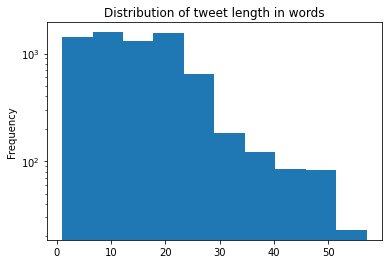

In [ ]:
#new_df = old_df[((old_df['C1'] > 0) & (old_df['C1'] < 20)) & ((old_df['C2'] > 0) & (old_df['C2'] < 20)) & ((old_df['C3'] > 0) & (old_df['C3'] < 20))]
new_df = (df[(df['class'] == 0)&(df['binary_pred'] == 0)])

# print('Average word length of tweet in dataset is {0:.0f}.'.format(np.mean(new_df['tweets'].apply(lambda x: len(x.split())))))

new_df['tweets'].apply(lambda x: len(x.split())).plot(kind='hist')
plt.yscale('log');
plt.title('Distribution of tweet length in words')